<a href="https://colab.research.google.com/github/jrakhshanda/Deep-Learning/blob/master/trafficSign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle --upgrade

In [177]:
# Info on how to get your api key (kaggle.json) here: https://github.com/Kaggle/kaggle-api#api-credentials
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json
api_token = {"username":"rakhshandajabeen55","key":"2483f350dd73f648b655ddd3456c3ce1"}
import json
import zipfile
import os
!chmod 600 /root
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json
!kaggle config path -p /content
!kaggle competitions download -c sweden-traffic-signs-classification
os.chdir('/content/')

sample.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
data.rar: Skipping, found more recently modified local copy (use --force to force download)
data.zip: Skipping, found more recently modified local copy (use --force to force download)
preprocessed.rar: Skipping, found more recently modified local copy (use --force to force download)


In [178]:
from zipfile import ZipFile
with ZipFile('/content/data.zip', 'r') as zipObj:
    print(zipObj)
    zipObj.extractall("data")

<zipfile.ZipFile filename='/content/data.zip' mode='r'>


In [179]:
import pandas as pd
import numpy as np
import keras
import tensorflow as tf 
from PIL import Image

from keras.models import Sequential
from keras.layers import  Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPool2D
from keras import backend as K
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical

from sklearn.utils import shuffle,class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import random
from matplotlib import pyplot as plt
from matplotlib import cm

In [180]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

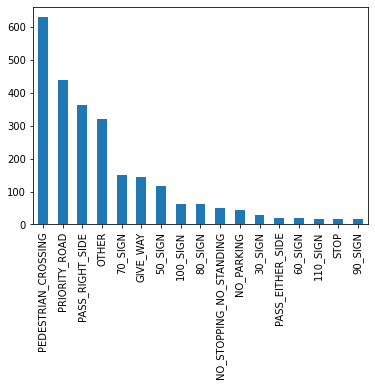

In [181]:
train["label"].value_counts().plot(kind = "bar")

In [182]:
train, validate = train_test_split(train, test_size=0.30, random_state=20)

In [ ]:
image_size = (40,40)
BatchSize = 64
# Scale data
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2
)
train_generator = train_datagen.flow_from_dataframe(
    train, 
    "/content/data/data", 
    x_col='file_name',
    y_col='label',
    target_size=image_size,
    class_mode='categorical',
    batch_size=BatchSize 
)
train_generator.image_shape

In [ ]:
# Scale data
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate, 
    "/content/data/data/", 
    x_col='file_name',
    y_col='label',
    target_size=image_size,
    class_mode='categorical',
    batch_size=BatchSize
)
validation_generator.image_shape

In [255]:
def createModel( num_classes,input_shape,class_weights):
  model = Sequential()
  model.add(Conv2D(16,kernel_size=(3,3),activation= "relu",input_shape = input_shape))
  model.add(Conv2D(16,kernel_size=(3,3),activation= "relu")) 

  model.add(Conv2D(32,kernel_size=(3,3),activation= "relu"))
  model.add(Conv2D(32,kernel_size=(3,3),activation= "relu"))

  model.add(Conv2D(64,kernel_size=(3,3),activation= "relu"))
  model.add(Conv2D(64,kernel_size=(3,3),activation= "relu"))
  model.add(MaxPool2D(pool_size=(2, 2)))
 
  model.add(Flatten())
  model.add(Dense(1024,activation= 'relu'))
  model.add(Dense(128,activation= 'relu'))
  model.add(Dense(64,activation= 'relu'))

  model.add(Dense(num_classes,activation='softmax'))
  model.compile(loss = keras.losses.categorical_crossentropy, optimizer = keras.optimizers.Adam(learning_rate= 0.0003),metrics =['accuracy'])

  return model

num_classes = 17
input_shape = (40,40,3)
model = createModel(num_classes,input_shape,weights)

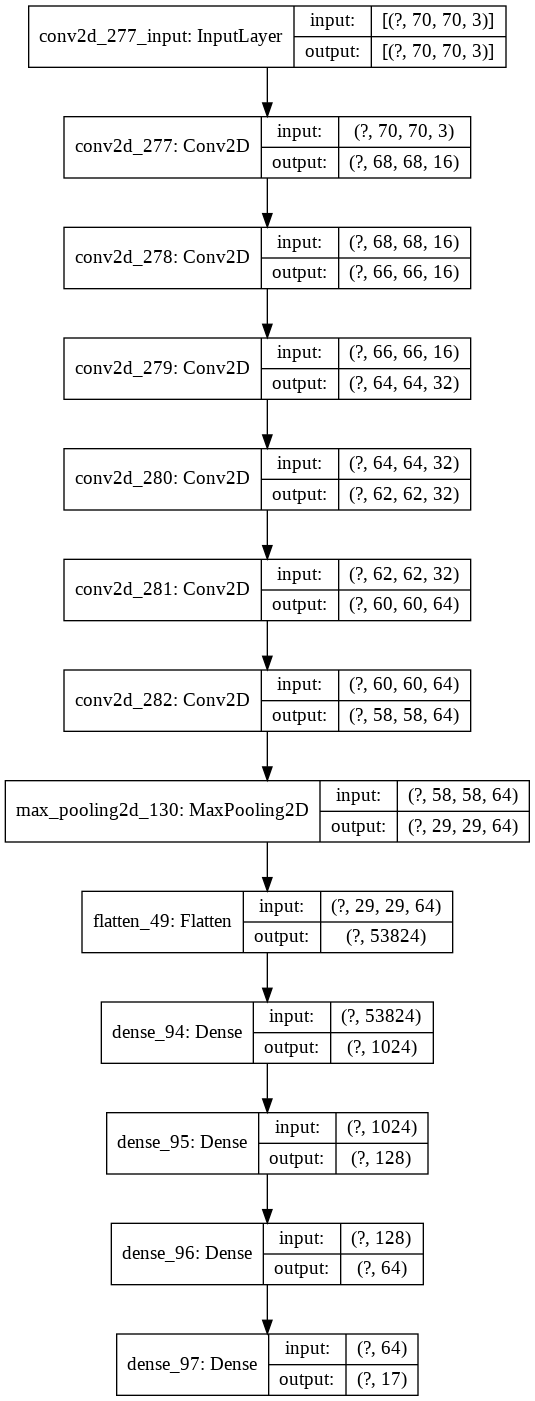

In [256]:
keras.utils.plot_model(model,show_shapes= True,show_layer_names=True)

In [257]:
earlyStop = EarlyStopping(patience = 10)
variable_gradient = ReduceLROnPlateau(monitor='val_accuracy', patience=2, factor=0.5, min_lr=0.001)
weights = class_weight.compute_class_weight('balanced',np.unique(train['label']),train['label'])
weights = {index:value for index,value in enumerate(weights)}

In [259]:
epochs = 20
history = model.fit(train_generator, 
                    epochs=epochs,
                    class_weight=weights,
                    validation_data=validation_generator,
                    callbacks=[earlyStop,variable_gradient]
)

Epoch 1/20
28/28 [==============================] - 5s 167ms/step - loss: 1.7593 - accuracy: 0.5029 - val_loss: 1.3532 - val_accuracy: 0.4807
Epoch 2/20
28/28 [==============================] - 5s 168ms/step - loss: 1.6825 - accuracy: 0.4732 - val_loss: 1.2186 - val_accuracy: 0.6005
Epoch 3/20
28/28 [==============================] - 5s 166ms/step - loss: 1.6761 - accuracy: 0.5029 - val_loss: 1.1550 - val_accuracy: 0.6099
Epoch 4/20
28/28 [==============================] - 5s 169ms/step - loss: 1.6473 - accuracy: 0.5023 - val_loss: 1.1314 - val_accuracy: 0.6138
Epoch 5/20
28/28 [==============================] - 5s 168ms/step - loss: 1.5656 - accuracy: 0.5274 - val_loss: 1.0269 - val_accuracy: 0.6192
Epoch 6/20
28/28 [==============================] - 5s 170ms/step - loss: 1.5687 - accuracy: 0.5080 - val_loss: 1.0094 - val_accuracy: 0.6525
Epoch 7/20
28/28 [==============================] - 5s 170ms/step - loss: 1.5631 - accuracy: 0.5405 - val_loss: 1.0653 - val_accuracy: 0.6085
Epoch 

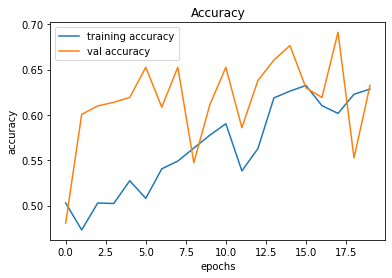

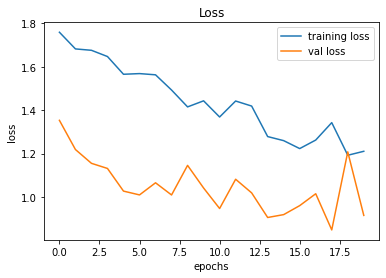

In [261]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [238]:
validation_generator.reset()
predIdxs = model.predict_generator(validation_generator)
predIdxsClasses = np.argmax(predIdxs, axis=1)
print(classification_report(validation_generator.classes, predIdxsClasses, target_names=validation_generator.class_indices))

                         precision    recall  f1-score   support

               100_SIGN       0.03      0.10      0.04        20
               110_SIGN       0.00      0.00      0.00         4
                30_SIGN       0.08      0.08      0.08        13
                50_SIGN       0.00      0.00      0.00        37
                60_SIGN       0.00      0.00      0.00         2
                70_SIGN       0.00      0.00      0.00        50
                80_SIGN       0.00      0.00      0.00        24
                90_SIGN       0.00      0.00      0.00         3
               GIVE_WAY       0.09      0.09      0.09        44
             NO_PARKING       0.00      0.00      0.00        14
NO_STOPPING_NO_STANDING       0.00      0.00      0.00        17
                  OTHER       0.00      0.00      0.00        96
       PASS_EITHER_SIDE       0.01      0.17      0.01         6
        PASS_RIGHT_SIDE       0.00      0.00      0.00       113
    PEDESTRIAN_CROSSING 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [53]:
model.save('trafficSign')

INFO:tensorflow:Assets written to: trafficSign/assets


In [56]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test, 
    "/content/data/data/", 
    x_col='file_name',
    y_col=None,
    target_size=(70,70),
    class_mode=None,
    batch_size=32
)

Found 610 validated image filenames.


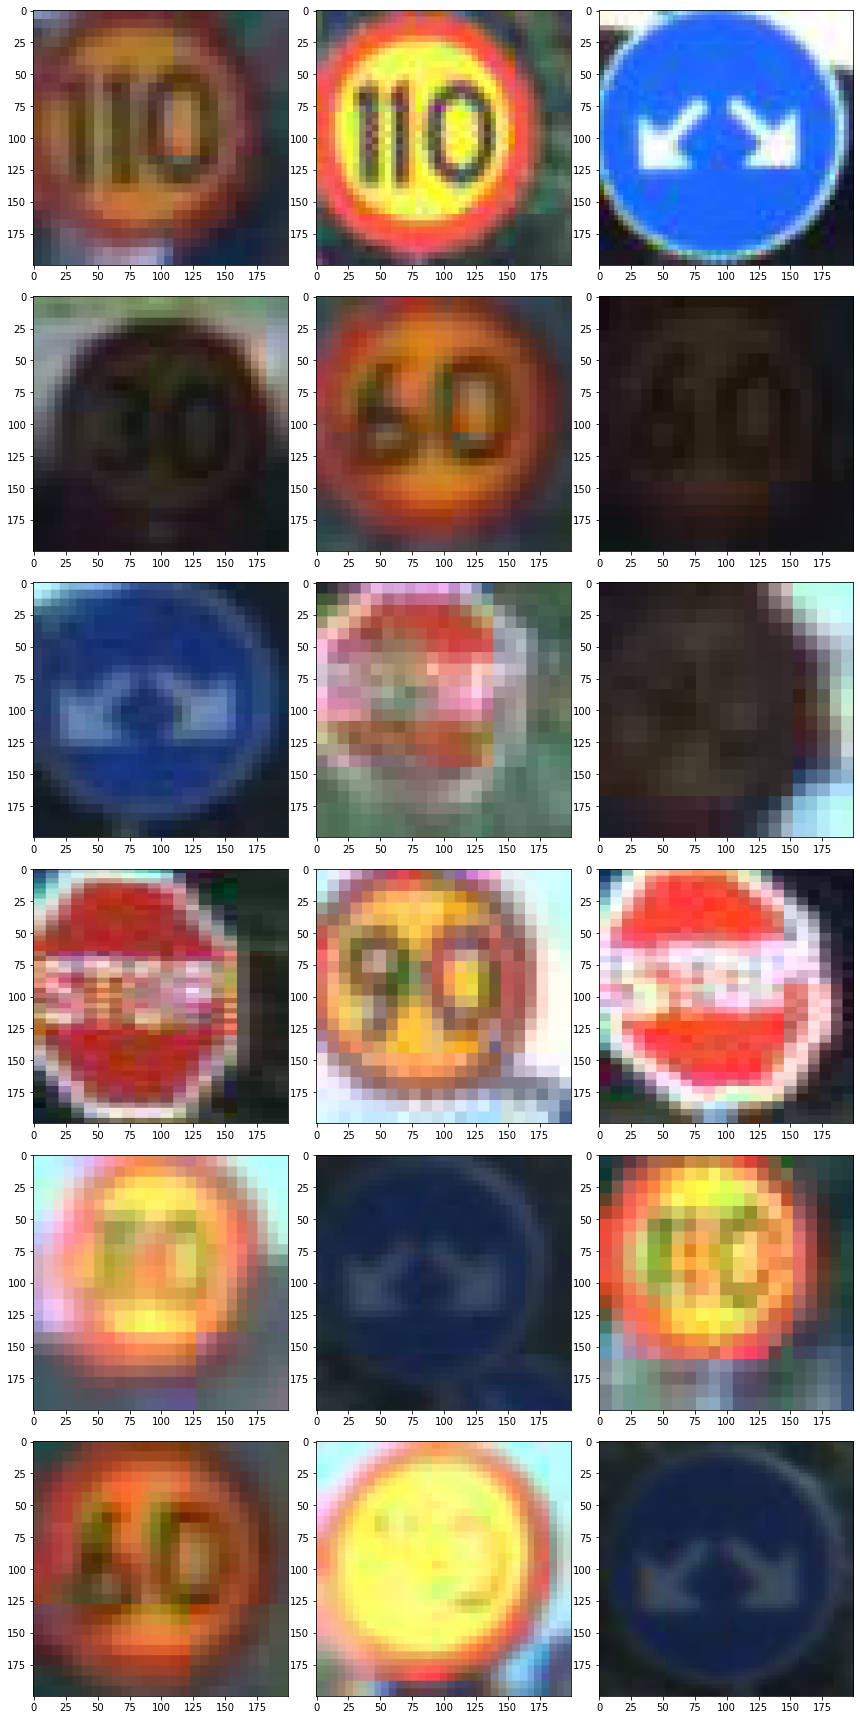

In [57]:
sample_test = test.head(18)
sample_test.head()
pyplot.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['file_name']
    img = load_img("/content/data/data/"+filename, target_size=(200,200))
    pyplot.subplot(6, 3, index+1)
    pyplot.imshow(img)
pyplot.tight_layout()
pyplot.show()